In [25]:
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

from multilevel_cutpoint_model import CutpointModel
from discrete_ci import discrete_ci

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from node import Node

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Make Moons

In [26]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [27]:
# y_moon indicates if the data will be in the first bucket or the second
N = 10000
X, y_moon = make_moons(n_samples = N, noise=0.3, random_state=1978)

# drop 1/2 of the 1 moons 
# want y_moon plot to look even and censoring to look even
# try higher value of sigmoid if it can't find the cutpoint
combined = np.append(X, y_moon[:,None], 1)
combined_sorted = combined[combined[:, -1].argsort()]
combined_sorted = combined_sorted[:7500,:]
np.random.shuffle(combined_sorted)
X = combined_sorted[:,:-1]
y_moon = combined_sorted[:,-1]

t_min = 0
t_boundary = 67
t_max = 100
t = np.zeros(len(y_moon))

s = np.random.binomial(1, 0.5, len(y_moon))
# s = np.random.binomial(1, 1, len(y_moon))

for ii in range(0, len(y_moon)):
    if y_moon[ii] == 0:
        t[ii] = np.random.uniform(t_min, t_boundary)
    elif y_moon[ii] == 1:
        
        t[ii] = np.random.uniform(t_boundary, t_max)
        
# t = t[1:int(N * 3/4)]
# s = s[1:int(N * 3/4)]
# y_moon = y_moon[1:int(N * 3/4)]
# X = X[1:int(N * 3/4), :]

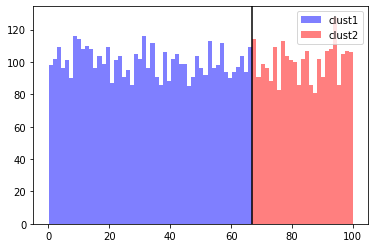

In [28]:
plt.hist(t[y_moon==0], bins=50, alpha = 0.5, color = "blue", label="clust1")
plt.hist(t[y_moon==1], bins=25, alpha = 0.5, color = "red", label="clust2")
plt.axvline(t_boundary, color="black")
plt.legend()
plt.show()

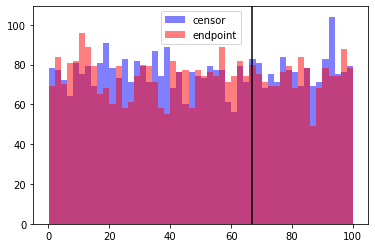

In [29]:
plt.hist(t[s==0], bins=50, alpha = 0.5, color = "blue", label="censor")
plt.hist(t[s==1], bins=50, alpha = 0.5, color = "red", label="endpoint")
plt.axvline(t_boundary, color="black")
plt.legend()
plt.show()

In [30]:
X_train, X_test, \
t_train, t_test,\
s_train, s_test = train_test_split(
    X, t, s, test_size=0.2, random_state=1978
)

In [39]:
from multilevel_cutpoint_model import CutpointModel

m = CutpointModel(X_train, t_train, s_train, sigmoid_temperature = 0.001, depth = 0, iterations = 250, prior_strength = 0.75)
m.train()

1
loss 0.19266295433044434
cutpoint 0.25
2
loss 0.1184273362159729
cutpoint 0.25999999046325684
3
loss 0.05848473310470581
cutpoint 0.26976126432418823
4
loss 0.013938665390014648
cutpoint 0.2791878879070282
5
loss -0.018333643674850464
cutpoint 0.2883753180503845
6
loss -0.03930214047431946
cutpoint 0.29683515429496765
7
loss -0.051884084939956665
cutpoint 0.3045228123664856
8
loss -0.058887988328933716
cutpoint 0.311579167842865
9
loss -0.06218555569648743
cutpoint 0.31775397062301636
10
loss -0.063946932554245
cutpoint 0.32235950231552124
11
loss -0.06555166840553284
cutpoint 0.32534119486808777
12
loss -0.06770530343055725
cutpoint 0.3272548317909241
13
loss -0.07064509391784668
cutpoint 0.3279264271259308
14
loss -0.07446315884590149
cutpoint 0.32745879888534546
15
loss -0.07885152101516724
cutpoint 0.32609978318214417
16
loss -0.0833619236946106
cutpoint 0.32424789667129517
17
loss -0.08789145946502686
cutpoint 0.3220358192920685
18
loss -0.09186714887619019
cutpoint 0.3195344209

146
loss -0.3099636733531952
cutpoint 0.6692357659339905
147
loss -0.3107590675354004
cutpoint 0.669575035572052
148
loss -0.3114785850048065
cutpoint 0.669837236404419
149
loss -0.31222695112228394
cutpoint 0.6697870492935181
150
loss -0.31297510862350464
cutpoint 0.6694996356964111
151
loss -0.31366080045700073
cutpoint 0.6692706942558289
152
loss -0.3143612742424011
cutpoint 0.669324517250061
153
loss -0.3150519132614136
cutpoint 0.6695796847343445
154
loss -0.3156934082508087
cutpoint 0.6697604060173035
155
loss -0.31634533405303955
cutpoint 0.6696966290473938
156
loss -0.31698179244995117
cutpoint 0.6694708466529846
157
loss -0.3175795376300812
cutpoint 0.6693223118782043
158
loss -0.3181830644607544
cutpoint 0.6693969964981079
159
loss -0.31876522302627563
cutpoint 0.6695948243141174
160
loss -0.31931495666503906
cutpoint 0.6696990132331848
161
loss -0.3198627233505249
cutpoint 0.6696121692657471
162
loss -0.3203849196434021
cutpoint 0.6694398522377014
163
loss -0.320881664752960

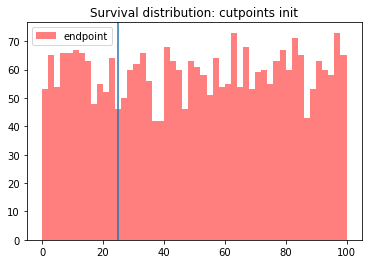

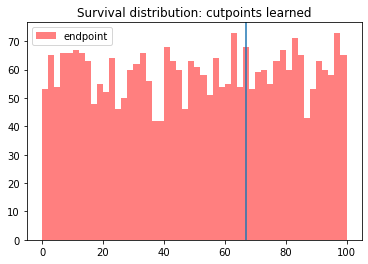

In [40]:
m.plot_result(t_train[s_train==1], t_train[s_train==0], label_true="endpoint", label_false="censored")

In [41]:
discrete_ci(m.predict(X_train), m.cutpoints, t_train, s_train, t_train)

0.8139319065463175

In [42]:
discrete_ci(m.predict(X_test), m.cutpoints, t_test, s_test, t_train)

0.8069340872673487

In [43]:
discrete_ci(m.predict(X_test), m.cutpoint0, t_test, s_test, t_train)

0.6977613234376083

## Tri-modal

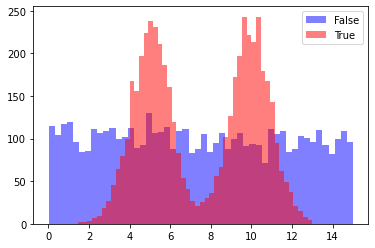

In [51]:
# shifted and scaled sigmoid function
def test_sigmoid(x, a=0, b=1.):
    return 1 / (1 + (np.exp(-1 * (x - a) / b)))

N = 10000
P = 5

rs = np.random.RandomState(1978)

X = rs.randn(N, P)
w = rs.randn(P)

s_prob = test_sigmoid(X @ w)
s = (rs.rand(N) < s_prob).astype(int)
t = (rs.randn(N) * s + 5 * s + (rs.rand(N)> 0.5) * 5 * s + 15 * rs.rand(N) * (1-s) )

# make times positive
t += abs(min(t))

plt.hist(t[s==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[s==1], bins=50, alpha = 0.5, color = "red", label="True")
plt.legend()
plt.show()

In [58]:
from multilevel_cutpoint_model import CutpointModel

m = CutpointModel(X, t, s, sigmoid_temperature = 0.001, depth =0, iterations = 250, prior_strength = 0.75)
m.train()

1
loss 0.6056146621704102
cutpoint 0.25
2
loss 0.4653373062610626
cutpoint 0.25999999046325684
3
loss 0.33833757042884827
cutpoint 0.2700057029724121
4
loss 0.23112738132476807
cutpoint 0.27994251251220703
5
loss 0.14864236116409302
cutpoint 0.2898108661174774
6
loss 0.08222046494483948
cutpoint 0.2994645833969116
7
loss 0.03261825442314148
cutpoint 0.30896836519241333
8
loss -0.0028097033500671387
cutpoint 0.3182537853717804
9
loss -0.02539914846420288
cutpoint 0.32709604501724243
10
loss -0.037794530391693115
cutpoint 0.3353872299194336
11
loss -0.040815502405166626
cutpoint 0.34319373965263367
12
loss -0.03737097978591919
cutpoint 0.3500480353832245
13
loss -0.03014346957206726
cutpoint 0.35578420758247375
14
loss -0.022969752550125122
cutpoint 0.36032620072364807
15
loss -0.016094177961349487
cutpoint 0.36380067467689514
16
loss -0.011206179857254028
cutpoint 0.36618712544441223
17
loss -0.008423030376434326
cutpoint 0.3676132261753082
18
loss -0.007953524589538574
cutpoint 0.36806

144
loss -0.06706947088241577
cutpoint 0.3106454908847809
145
loss -0.06709593534469604
cutpoint 0.31064391136169434
146
loss -0.06712186336517334
cutpoint 0.310637503862381
147
loss -0.0671476423740387
cutpoint 0.310627818107605
148
loss -0.06717255711555481
cutpoint 0.3106168210506439
149
loss -0.06719696521759033
cutpoint 0.3106065094470978
150
loss -0.06722092628479004
cutpoint 0.3105984628200531
151
loss -0.06724393367767334
cutpoint 0.3105936348438263
152
loss -0.06726637482643127
cutpoint 0.3105922043323517
153
loss -0.06728819012641907
cutpoint 0.3105936646461487
154
loss -0.06730958819389343
cutpoint 0.3105970323085785
155
loss -0.06733107566833496
cutpoint 0.31060105562210083
156
loss -0.06735238432884216
cutpoint 0.3106045722961426
157
loss -0.06737351417541504
cutpoint 0.31060662865638733
158
loss -0.0673944354057312
cutpoint 0.31060677766799927
159
loss -0.0674152672290802
cutpoint 0.3106050491333008
160
loss -0.06743583083152771
cutpoint 0.31060197949409485
161
loss -0.06

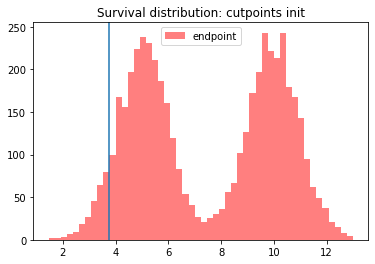

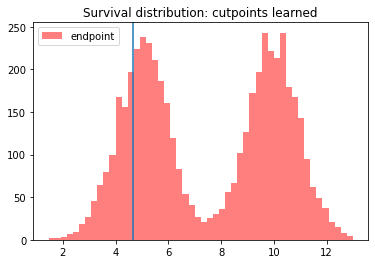

In [62]:
m.plot_result(t[s==1], t[s==0], label_true="endpoint", label_false="censored")

In [63]:
discrete_ci(m.predict(X), m.cutpoints, t, s, t)

0.3699953952657088

In [64]:
discrete_ci(m.predict(X), m.cutpoint0, t, s, t)

0.3627345547635403

## more modes

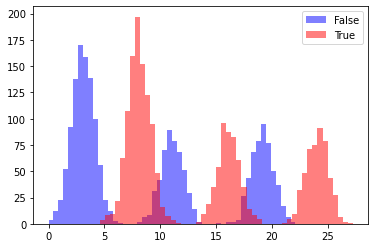

In [37]:
# shifted and scaled sigmoid function
def test_sigmoid(x, a=0, b=1.):
    return 1 / (1 + (np.exp(-1 * (x - a) / b)))

N = 1000
P = 5

rs = np.random.RandomState(1978)

X = rs.randn(N, P)
w = rs.randn(P)

s_prob = test_sigmoid(X @ w)
s = (rs.rand(N) < s_prob).astype(int)
t = (rs.randn(N) + 5 * y )


for i in range(0, 3):
    X_i = rs.randn(N, P)
    w_i = rs.randn(P)

    s_prob = test_sigmoid(X_i @ w_i)
    s_i = (rs.rand(N) < s_prob).astype(int)
    t_i = (rs.randn(N) + 8 * i + 5 * s_i )
    X = np.concatenate((X, X_i))
    t = np.concatenate((t, t_i))
    s = np.concatenate((s, s_i))
    

# make times positive
t += abs(min(t))

plt.hist(t[s==0], bins=50, alpha = 0.5, color = "blue", label="False")
plt.hist(t[s==1], bins=50, alpha = 0.5, color = "red", label="True")
plt.legend()
plt.show()

In [39]:
m = CutpointModel(X, t, s, sigmoid_temperature = 0.001, depth =2, iterations = 250, prior_strength = 0.75)
m.train()


1
loss 3.357884168624878
cutpoint 0.25
2
loss 3.3767969608306885
cutpoint 0.25999999046325684
3
loss 3.165541410446167
cutpoint 0.2549611032009125
4
loss 3.0838847160339355
cutpoint 0.24966304004192352
5
loss 3.022533655166626
cutpoint 0.2478320598602295
6
loss 2.9206395149230957
cutpoint 0.24887283146381378
7
loss 2.813730478286743
cutpoint 0.25179430842399597
8
loss 2.733790874481201
cutpoint 0.2556770443916321
9
loss 2.6722545623779297
cutpoint 0.2588643729686737
10
loss 2.6036336421966553
cutpoint 0.26071682572364807
11
loss 2.522716522216797
cutpoint 0.26166799664497375
12
loss 2.4419450759887695
cutpoint 0.26233017444610596
13
loss 2.3688721656799316
cutpoint 0.2633027136325836
14
loss 2.3050918579101562
cutpoint 0.2650379240512848
15
loss 2.241570472717285
cutpoint 0.2677825391292572
16
loss 2.1702990531921387
cutpoint 0.2715878486633301
17
loss 2.098790168762207
cutpoint 0.2760724127292633
18
loss 2.027770519256592
cutpoint 0.28102803230285645
19
loss 1.9600493907928467
cutpoin

149
loss 0.607982337474823
cutpoint 0.41012462973594666
150
loss 0.6076734662055969
cutpoint 0.41016077995300293
151
loss 0.6073705554008484
cutpoint 0.41020217537879944
152
loss 0.6070736646652222
cutpoint 0.4102488160133362
153
loss 0.606782853603363
cutpoint 0.4103008806705475
154
loss 0.6064977645874023
cutpoint 0.4103586971759796
155
loss 0.6062180995941162
cutpoint 0.41042253375053406
156
loss 0.6059437990188599
cutpoint 0.41049259901046753
157
loss 0.6056738495826721
cutpoint 0.4105691909790039
158
loss 0.6054091453552246
cutpoint 0.4106528162956238
159
loss 0.6051479578018188
cutpoint 0.4107445180416107
160
loss 0.6048911809921265
cutpoint 0.41084614396095276
161
loss 0.6046379804611206
cutpoint 0.41096046566963196
162
loss 0.604387104511261
cutpoint 0.41109156608581543
163
loss 0.6041384935379028
cutpoint 0.4112449884414673
164
loss 0.6038903594017029
cutpoint 0.4114280939102173
165
loss 0.6036399006843567
cutpoint 0.4116504490375519
166
loss 0.6033840775489807
cutpoint 0.4119

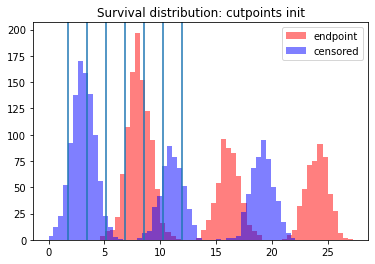

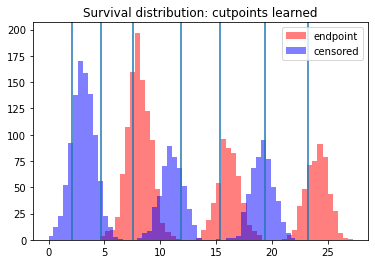

In [46]:
m.plot_result(t[s==1], t[s==0], label_true="endpoint", label_false="censored")

# Sksurv data

## Breast Cancer

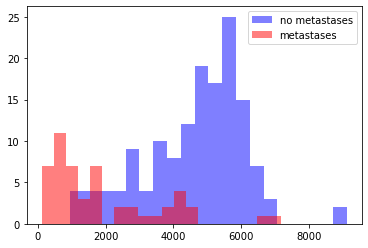

In [58]:
from sksurv.datasets import load_breast_cancer

data_x, data_y = load_breast_cancer()
y_df = pd.DataFrame.from_records(data_y)

# cut last covariates that are strings
X = data_x.iloc[:, 1:-3].values

t = np.array(y_df["t.tdm"])
s = np.array(y_df["e.tdm"])


plt.hist(y_df[~y_df["e.tdm"]]["t.tdm"], bins = 20, alpha=0.5, color="blue", label="no metastases")
plt.hist(y_df[y_df["e.tdm"]]["t.tdm"], bins = 20, alpha=0.5, color="red", label="metastases")
plt.legend()

plt.show()

In [64]:
m = CutpointModel(X, t, s, sigmoid_temperature = 0.001, depth =1, iterations = 5000, prior_strength = 0.75)
m.train()


1
loss 6.852795124053955
cutpoint 0.25
2
loss 4.0292744636535645
cutpoint 0.25999999046325684
3
loss 1.102662444114685
cutpoint 0.26831212639808655
4
loss 1.7326816320419312
cutpoint 0.2628672122955322
5
loss 2.3204894065856934
cutpoint 0.25554826855659485
6
loss 2.4749844074249268
cutpoint 0.24730215966701508
7
loss 2.585366725921631
cutpoint 0.23851080238819122
8
loss 2.5535008907318115
cutpoint 0.22931547462940216
9
loss 2.419473171234131
cutpoint 0.22063298523426056
10
loss 2.2246246337890625
cutpoint 0.2118949592113495
11
loss 2.615278720855713
cutpoint 0.20283827185630798
12
loss 1.9989001750946045
cutpoint 0.193852037191391
13
loss 1.7149217128753662
cutpoint 0.18459458649158478
14
loss 1.630098581314087
cutpoint 0.17496240139007568
15
loss 1.64041268825531
cutpoint 0.1665009707212448
16
loss 1.580043077468872
cutpoint 0.1598011553287506
17
loss 1.4746575355529785
cutpoint 0.15562736988067627
18
loss 1.360624074935913
cutpoint 0.15338961780071259
19
loss 1.2983934879302979
cutpo

159
loss 0.5857478976249695
cutpoint 0.07459766417741776
160
loss 0.5851839780807495
cutpoint 0.07460416108369827
161
loss 0.5846244692802429
cutpoint 0.07461066544055939
162
loss 0.5840719938278198
cutpoint 0.07461367547512054
163
loss 0.583519697189331
cutpoint 0.07461179792881012
164
loss 0.5829726457595825
cutpoint 0.074606753885746
165
loss 0.5824246406555176
cutpoint 0.07460230588912964
166
loss 0.581885814666748
cutpoint 0.07460181415081024
167
loss 0.58134925365448
cutpoint 0.07460618019104004
168
loss 0.5808130502700806
cutpoint 0.07461337745189667
169
loss 0.5802798867225647
cutpoint 0.0746198520064354
170
loss 0.5797519683837891
cutpoint 0.07462281733751297
171
loss 0.5792301297187805
cutpoint 0.07462181895971298
172
loss 0.5787081122398376
cutpoint 0.07461874932050705
173
loss 0.5781903862953186
cutpoint 0.07461635023355484
174
loss 0.5776752233505249
cutpoint 0.0746164321899414
175
loss 0.5771618485450745
cutpoint 0.07461891323328018
176
loss 0.5766535997390747
cutpoint 0.

cutpoint 0.07471061497926712
307
loss 0.5307903289794922
cutpoint 0.07471105456352234
308
loss 0.5305449366569519
cutpoint 0.07471150159835815
309
loss 0.5303019881248474
cutpoint 0.07471193373203278
310
loss 0.5300599932670593
cutpoint 0.0747123584151268
311
loss 0.5298160910606384
cutpoint 0.07471278309822083
312
loss 0.5295745134353638
cutpoint 0.07471320778131485
313
loss 0.529333233833313
cutpoint 0.07471363246440887
314
loss 0.5290951728820801
cutpoint 0.0747140645980835
315
loss 0.5288581848144531
cutpoint 0.07471449673175812
316
loss 0.5286204814910889
cutpoint 0.07471492141485214
317
loss 0.5283852219581604
cutpoint 0.07471534609794617
318
loss 0.52814781665802
cutpoint 0.074715755879879
319
loss 0.5279120206832886
cutpoint 0.07471617311239243
320
loss 0.5276778936386108
cutpoint 0.07471659034490585
321
loss 0.5274461507797241
cutpoint 0.07471700757741928
322
loss 0.5272154808044434
cutpoint 0.07471742480993271
323
loss 0.5269855260848999
cutpoint 0.07471784204244614
324
loss 

463
loss 0.5006301999092102
cutpoint 0.07477022707462311
464
loss 0.5004677772521973
cutpoint 0.07477058470249176
465
loss 0.5003110766410828
cutpoint 0.07477093487977982
466
loss 0.5001530051231384
cutpoint 0.07477129250764847
467
loss 0.49999672174453735
cutpoint 0.07477165758609772
468
loss 0.4998409152030945
cutpoint 0.07477202266454697
469
loss 0.49968135356903076
cutpoint 0.07477238029241562
470
loss 0.4995232820510864
cutpoint 0.07477273792028427
471
loss 0.49936825037002563
cutpoint 0.07477309554815292
472
loss 0.49921169877052307
cutpoint 0.07477345317602158
473
loss 0.499057412147522
cutpoint 0.07477381825447083
474
loss 0.4989009499549866
cutpoint 0.07477417588233948
475
loss 0.49874550104141235
cutpoint 0.07477453351020813
476
loss 0.49858903884887695
cutpoint 0.07477489113807678
477
loss 0.4984355568885803
cutpoint 0.07477524876594543
478
loss 0.49827879667282104
cutpoint 0.07477561384439468
479
loss 0.4981260895729065
cutpoint 0.07477597147226334
480
loss 0.49797341227531

613
loss 0.4835214912891388
cutpoint 0.07482263445854187
614
loss 0.4820857644081116
cutpoint 0.074822798371315
615
loss 0.4825212359428406
cutpoint 0.07482306659221649
616
loss 0.4810665249824524
cutpoint 0.0748244971036911
617
loss 0.4808303117752075
cutpoint 0.07482538372278214
618
loss 0.47998738288879395
cutpoint 0.07482597976922989
619
loss 0.47968003153800964
cutpoint 0.0748254582285881
620
loss 0.4792647361755371
cutpoint 0.07482507079839706
621
loss 0.4790418744087219
cutpoint 0.07482510805130005
622
loss 0.4788151979446411
cutpoint 0.07482612878084183
623
loss 0.47865432500839233
cutpoint 0.07482725381851196
624
loss 0.4784979522228241
cutpoint 0.07482801377773285
625
loss 0.47836828231811523
cutpoint 0.07482794672250748
626
loss 0.4782406985759735
cutpoint 0.07482761889696121
627
loss 0.47812461853027344
cutpoint 0.07482744008302689
628
loss 0.4780139923095703
cutpoint 0.07482791692018509
629
loss 0.47791942954063416
cutpoint 0.07482875138521194
630
loss 0.4778260588645935
c

771
loss 0.46344345808029175
cutpoint 0.07487733662128448
772
loss 0.4631853699684143
cutpoint 0.0748780220746994
773
loss 0.46313005685806274
cutpoint 0.07487804442644119
774
loss 0.46295401453971863
cutpoint 0.07487868517637253
775
loss 0.46295619010925293
cutpoint 0.07487868517637253
776
loss 0.4628329873085022
cutpoint 0.07487937062978745
777
loss 0.46292245388031006
cutpoint 0.07487938553094864
778
loss 0.46282297372817993
cutpoint 0.07488013803958893
779
loss 0.4630475342273712
cutpoint 0.07488004863262177
780
loss 0.4629344046115875
cutpoint 0.07488082349300385
781
loss 0.4633485674858093
cutpoint 0.07488060742616653
782
loss 0.46312224864959717
cutpoint 0.07488152384757996
783
loss 0.46370401978492737
cutpoint 0.07488121837377548
784
loss 0.4632278382778168
cutpoint 0.07488226890563965
785
loss 0.46378499269485474
cutpoint 0.074881911277771
786
loss 0.4630543291568756
cutpoint 0.07488300651311874
787
loss 0.4633755087852478
cutpoint 0.0748826190829277
788
loss 0.462599337100982

loss 0.45074737071990967
cutpoint 0.07493109256029129
926
loss 0.45041072368621826
cutpoint 0.07493261992931366
927
loss 0.4505904018878937
cutpoint 0.074931800365448
928
loss 0.45026010274887085
cutpoint 0.07493332773447037
929
loss 0.4504571259021759
cutpoint 0.07493249326944351
930
loss 0.45012831687927246
cutpoint 0.07493405789136887
931
loss 0.4503404498100281
cutpoint 0.07493318617343903
932
loss 0.4499993920326233
cutpoint 0.07493477314710617
933
loss 0.45022469758987427
cutpoint 0.07493387162685394
934
loss 0.4498717784881592
cutpoint 0.07493550330400467
935
loss 0.45010191202163696
cutpoint 0.07493457198143005
936
loss 0.44973188638687134
cutpoint 0.07493621110916138
937
loss 0.4499542713165283
cutpoint 0.07493525743484497
938
loss 0.44957447052001953
cutpoint 0.07493694126605988
939
loss 0.4497882127761841
cutpoint 0.07493597269058228
940
loss 0.44940391182899475
cutpoint 0.07493764162063599
941
loss 0.44960200786590576
cutpoint 0.07493667304515839
942
loss 0.4492255449295044

1077
loss 0.43982285261154175
cutpoint 0.07498269528150558
1078
loss 0.4394460916519165
cutpoint 0.07498574256896973
1079
loss 0.43969303369522095
cutpoint 0.07498335838317871
1080
loss 0.4393151104450226
cutpoint 0.07498641312122345
1081
loss 0.43955913186073303
cutpoint 0.07498397678136826
1082
loss 0.4391796588897705
cutpoint 0.07498709112405777
1083
loss 0.4394266903400421
cutpoint 0.07498462498188019
1084
loss 0.4390489161014557
cutpoint 0.0749877467751503
1085
loss 0.43929508328437805
cutpoint 0.07498526573181152
1086
loss 0.43891236186027527
cutpoint 0.07498842477798462
1087
loss 0.4391590654850006
cutpoint 0.07498589903116226
1088
loss 0.43878018856048584
cutpoint 0.07498908042907715
1089
loss 0.4390270709991455
cutpoint 0.0749865472316742
1090
loss 0.438646137714386
cutpoint 0.07498975098133087
1091
loss 0.4388926029205322
cutpoint 0.07498717308044434
1092
loss 0.438510537147522
cutpoint 0.074990414083004
1093
loss 0.43876034021377563
cutpoint 0.07498780637979507
1094
loss 0.4

1233
loss 0.4301031827926636
cutpoint 0.0750286653637886
1234
loss 0.4297028183937073
cutpoint 0.07503493875265121
1235
loss 0.42998558282852173
cutpoint 0.07502920180559158
1236
loss 0.4295845031738281
cutpoint 0.07503552734851837
1237
loss 0.42987340688705444
cutpoint 0.07502971589565277
1238
loss 0.42947036027908325
cutpoint 0.07503612339496613
1239
loss 0.429756760597229
cutpoint 0.07503026723861694
1240
loss 0.429353803396225
cutpoint 0.07503670454025269
1241
loss 0.4296436607837677
cutpoint 0.07503077387809753
1242
loss 0.4292398989200592
cutpoint 0.07503730058670044
1243
loss 0.42952728271484375
cutpoint 0.07503130286931992
1244
loss 0.4291243851184845
cutpoint 0.0750378966331482
1245
loss 0.42941272258758545
cutpoint 0.0750318244099617
1246
loss 0.429008424282074
cutpoint 0.07503847777843475
1247
loss 0.42929762601852417
cutpoint 0.07503233850002289
1248
loss 0.42889320850372314
cutpoint 0.07503906637430191
1249
loss 0.4291834831237793
cutpoint 0.07503287494182587
1250
loss 0.4

cutpoint 0.07506301254034042
1378
loss 0.42185044288635254
cutpoint 0.07507576048374176
1379
loss 0.42216938734054565
cutpoint 0.07506342232227325
1380
loss 0.42174577713012695
cutpoint 0.07507630437612534
1381
loss 0.42206764221191406
cutpoint 0.07506384700536728
1382
loss 0.4216459393501282
cutpoint 0.0750768706202507
1383
loss 0.42196643352508545
cutpoint 0.07506424933671951
1384
loss 0.42154502868652344
cutpoint 0.07507742196321487
1385
loss 0.4218634366989136
cutpoint 0.07506467401981354
1386
loss 0.42144083976745605
cutpoint 0.07507795840501785
1387
loss 0.42176389694213867
cutpoint 0.07506510615348816
1388
loss 0.4213413596153259
cutpoint 0.07507850974798203
1389
loss 0.42166125774383545
cutpoint 0.0750654935836792
1390
loss 0.42123931646347046
cutpoint 0.07507909089326859
1391
loss 0.42156222462654114
cutpoint 0.07506589591503143
1392
loss 0.42113709449768066
cutpoint 0.07507962733507156
1393
loss 0.4214596152305603
cutpoint 0.07506632804870605
1394
loss 0.4210365414619446
cutp

loss 0.4150833189487457
cutpoint 0.07508928328752518
1528
loss 0.41464269161224365
cutpoint 0.07511861622333527
1529
loss 0.4149935841560364
cutpoint 0.07508955150842667
1530
loss 0.4145514667034149
cutpoint 0.07511922717094421
1531
loss 0.4149026870727539
cutpoint 0.07508981972932816
1532
loss 0.414463073015213
cutpoint 0.07511983811855316
1533
loss 0.4148140549659729
cutpoint 0.07509007304906845
1534
loss 0.41437196731567383
cutpoint 0.0751204863190651
1535
loss 0.4147251844406128
cutpoint 0.07509030401706696
1536
loss 0.4142823815345764
cutpoint 0.07512112706899643
1537
loss 0.41463589668273926
cutpoint 0.07509054243564606
1538
loss 0.4141934812068939
cutpoint 0.07512175291776657
1539
loss 0.41454559564590454
cutpoint 0.07509080320596695
1540
loss 0.41410547494888306
cutpoint 0.07512237876653671
1541
loss 0.41445714235305786
cutpoint 0.07509103417396545
1542
loss 0.41401445865631104
cutpoint 0.07512303441762924
1543
loss 0.41436830163002014
cutpoint 0.07509125769138336
1544
loss 0.4

1682
loss 0.4081166386604309
cutpoint 0.07518429309129715
1683
loss 0.4084954857826233
cutpoint 0.07508993148803711
1684
loss 0.4080364406108856
cutpoint 0.07518566399812698
1685
loss 0.4084153175354004
cutpoint 0.07508940249681473
1686
loss 0.40795618295669556
cutpoint 0.0751870647072792
1687
loss 0.4083371162414551
cutpoint 0.07508885115385056
1688
loss 0.40787720680236816
cutpoint 0.07518850266933441
1689
loss 0.40825918316841125
cutpoint 0.0750882551074028
1690
loss 0.4077971577644348
cutpoint 0.07518996298313141
1691
loss 0.40817996859550476
cutpoint 0.07508763670921326
1692
loss 0.40771883726119995
cutpoint 0.07519147545099258
1693
loss 0.40810245275497437
cutpoint 0.07508697360754013
1694
loss 0.40764185786247253
cutpoint 0.07519301027059555
1695
loss 0.4080250859260559
cutpoint 0.07508626580238342
1696
loss 0.4075618386268616
cutpoint 0.07519461214542389
1697
loss 0.407945841550827
cutpoint 0.07508552074432373
1698
loss 0.4074844419956207
cutpoint 0.07519622147083282
1699
loss 

1837
loss 0.402925968170166
cutpoint 0.07489799708127975
1838
loss 0.4024393558502197
cutpoint 0.07545027136802673
1839
loss 0.4028557538986206
cutpoint 0.07489719986915588
1840
loss 0.40236979722976685
cutpoint 0.07545190304517746
1841
loss 0.4027840495109558
cutpoint 0.07489654421806335
1842
loss 0.4023010730743408
cutpoint 0.07545337080955505
1843
loss 0.4027143716812134
cutpoint 0.07489602267742157
1844
loss 0.4022291898727417
cutpoint 0.0754547268152237
1845
loss 0.4026433229446411
cutpoint 0.07489558309316635
1846
loss 0.4021596312522888
cutpoint 0.07545600086450577
1847
loss 0.40257251262664795
cutpoint 0.0748952329158783
1848
loss 0.4020894467830658
cutpoint 0.07545720785856247
1849
loss 0.40250343084335327
cutpoint 0.07489490509033203
1850
loss 0.4020184576511383
cutpoint 0.07545837759971619
1851
loss 0.4024326801300049
cutpoint 0.07489464432001114
1852
loss 0.40194737911224365
cutpoint 0.07545949518680573
1853
loss 0.40236181020736694
cutpoint 0.07489440590143204
1854
loss 0.

1990
loss 0.3973315358161926
cutpoint 0.07549252361059189
1991
loss 0.39775365591049194
cutpoint 0.07491941750049591
1992
loss 0.3972693681716919
cutpoint 0.07549287378787994
1993
loss 0.39768946170806885
cutpoint 0.07491987943649292
1994
loss 0.39720600843429565
cutpoint 0.0754932388663292
1995
loss 0.3976268172264099
cutpoint 0.07492034137248993
1996
loss 0.3971400260925293
cutpoint 0.07549363374710083
1997
loss 0.3975638747215271
cutpoint 0.07492076605558395
1998
loss 0.3970767855644226
cutpoint 0.07549402862787247
1999
loss 0.3975006937980652
cutpoint 0.07492121309041977
2000
loss 0.39701488614082336
cutpoint 0.0754944235086441
2001
loss 0.3974369168281555
cutpoint 0.07492164522409439
2002
loss 0.39695310592651367
cutpoint 0.07549479603767395
2003
loss 0.3973734378814697
cutpoint 0.074922114610672
2004
loss 0.396888792514801
cutpoint 0.0754951760172844
2005
loss 0.3973122537136078
cutpoint 0.07492256164550781
2006
loss 0.39682507514953613
cutpoint 0.07549553364515305
2007
loss 0.39

2139
loss 0.3932948708534241
cutpoint 0.07495255768299103
2140
loss 0.39280301332473755
cutpoint 0.07552097737789154
2141
loss 0.3932378888130188
cutpoint 0.07495304197072983
2142
loss 0.3927462100982666
cutpoint 0.0755213126540184
2143
loss 0.3931816816329956
cutpoint 0.07495351135730743
2144
loss 0.39269036054611206
cutpoint 0.07552167028188705
2145
loss 0.3931235074996948
cutpoint 0.07495397329330444
2146
loss 0.3926307260990143
cutpoint 0.0755220353603363
2147
loss 0.39306557178497314
cutpoint 0.07495442032814026
2148
loss 0.39257413148880005
cutpoint 0.07552242279052734
2149
loss 0.39301007986068726
cutpoint 0.07495485246181488
2150
loss 0.39251863956451416
cutpoint 0.07552282512187958
2151
loss 0.392952561378479
cutpoint 0.07495525479316711
2152
loss 0.39246195554733276
cutpoint 0.0755232498049736
2153
loss 0.392896443605423
cutpoint 0.07495565712451935
2154
loss 0.3924049735069275
cutpoint 0.07552368193864822
2155
loss 0.3928401470184326
cutpoint 0.07495605945587158
2156
loss 0.

2289
loss 0.38921216130256653
cutpoint 0.07498493790626526
2290
loss 0.38871586322784424
cutpoint 0.07554980367422104
2291
loss 0.38916072249412537
cutpoint 0.07498530298471451
2292
loss 0.3886653780937195
cutpoint 0.07555019855499268
2293
loss 0.38910794258117676
cutpoint 0.07498572766780853
2294
loss 0.3886141777038574
cutpoint 0.07555057853460312
2295
loss 0.3890577554702759
cutpoint 0.07498617470264435
2296
loss 0.3885621428489685
cutpoint 0.07555089890956879
2297
loss 0.3890049159526825
cutpoint 0.07498665899038315
2298
loss 0.38850897550582886
cutpoint 0.07555123418569565
2299
loss 0.3889539837837219
cutpoint 0.07498712092638016
2300
loss 0.388458788394928
cutpoint 0.07555156946182251
2301
loss 0.388902485370636
cutpoint 0.07498756796121597
2302
loss 0.38840633630752563
cutpoint 0.07555194944143295
2303
loss 0.3888511061668396
cutpoint 0.0749879851937294
2304
loss 0.38835638761520386
cutpoint 0.07555234432220459
2305
loss 0.38880041241645813
cutpoint 0.07498838007450104
2306
loss

2436
loss 0.38511234521865845
cutpoint 0.07557759433984756
2437
loss 0.38556352257728577
cutpoint 0.07501549273729324
2438
loss 0.3850669264793396
cutpoint 0.0755779966711998
2439
loss 0.38551661372184753
cutpoint 0.07501588016748428
2440
loss 0.38502031564712524
cutpoint 0.07557839900255203
2441
loss 0.3854696750640869
cutpoint 0.07501624524593353
2442
loss 0.3849731683731079
cutpoint 0.07557882368564606
2443
loss 0.38542306423187256
cutpoint 0.07501661032438278
2444
loss 0.38492661714553833
cutpoint 0.07557923346757889
2445
loss 0.38537609577178955
cutpoint 0.07501699030399323
2446
loss 0.3848792314529419
cutpoint 0.07557962834835052
2447
loss 0.3853294253349304
cutpoint 0.07501739263534546
2448
loss 0.38483238220214844
cutpoint 0.07557999342679977
2449
loss 0.3852827250957489
cutpoint 0.07501780986785889
2450
loss 0.38478633761405945
cutpoint 0.07558035850524902
2451
loss 0.38523679971694946
cutpoint 0.07501822710037231
2452
loss 0.3847411572933197
cutpoint 0.07558071613311768
2453


loss 0.3822953701019287
cutpoint 0.07504412531852722
2584
loss 0.3817998766899109
cutpoint 0.07560549676418304
2585
loss 0.38225245475769043
cutpoint 0.07504450529813766
2586
loss 0.3817558288574219
cutpoint 0.07560588419437408
2587
loss 0.3822095990180969
cutpoint 0.07504486292600632
2588
loss 0.38171470165252686
cutpoint 0.07560628652572632
2589
loss 0.38216733932495117
cutpoint 0.07504522800445557
2590
loss 0.3816726803779602
cutpoint 0.07560666650533676
2591
loss 0.3821254372596741
cutpoint 0.07504559308290482
2592
loss 0.38162994384765625
cutpoint 0.07560707628726959
2593
loss 0.3820834755897522
cutpoint 0.07504595071077347
2594
loss 0.38158637285232544
cutpoint 0.07560744881629944
2595
loss 0.38204124569892883
cutpoint 0.07504631578922272
2596
loss 0.38154542446136475
cutpoint 0.07560786604881287
2597
loss 0.38199853897094727
cutpoint 0.07504668086767197
2598
loss 0.3815044164657593
cutpoint 0.07560821622610092
2599
loss 0.38195592164993286
cutpoint 0.075047068297863
2600
loss 0.

2732
loss 0.37879103422164917
cutpoint 0.07563262432813644
2733
loss 0.37924623489379883
cutpoint 0.07507218420505524
2734
loss 0.3787536025047302
cutpoint 0.07563292980194092
2735
loss 0.3792080283164978
cutpoint 0.07507257908582687
2736
loss 0.3787122368812561
cutpoint 0.07563327997922897
2737
loss 0.37917008996009827
cutpoint 0.07507294416427612
2738
loss 0.37867501378059387
cutpoint 0.07563364505767822
2739
loss 0.3791313171386719
cutpoint 0.07507327944040298
2740
loss 0.37863677740097046
cutpoint 0.07563406974077225
2741
loss 0.37909287214279175
cutpoint 0.07507357746362686
2742
loss 0.37859949469566345
cutpoint 0.07563447952270508
2743
loss 0.37905365228652954
cutpoint 0.07507391273975372
2744
loss 0.37855982780456543
cutpoint 0.07563487440347672
2745
loss 0.3790157735347748
cutpoint 0.07507424801588058
2746
loss 0.3785207271575928
cutpoint 0.07563522458076477
2747
loss 0.3789759874343872
cutpoint 0.07507463544607162
2748
loss 0.3784829378128052
cutpoint 0.07563555985689163
2749


2881
loss 0.3765135407447815
cutpoint 0.07509858161211014
2882
loss 0.3760225474834442
cutpoint 0.07565893232822418
2883
loss 0.37647753953933716
cutpoint 0.0750989094376564
2884
loss 0.375986784696579
cutpoint 0.07565928250551224
2885
loss 0.3764433264732361
cutpoint 0.07509922981262207
2886
loss 0.3759520649909973
cutpoint 0.07565966993570328
2887
loss 0.37640804052352905
cutpoint 0.07509955763816833
2888
loss 0.3759179711341858
cutpoint 0.07566001266241074
2889
loss 0.3763728141784668
cutpoint 0.0750999003648758
2890
loss 0.3758816719055176
cutpoint 0.0756603479385376
2891
loss 0.3763372302055359
cutpoint 0.07510027289390564
2892
loss 0.37584617733955383
cutpoint 0.07566066086292267
2893
loss 0.376302570104599
cutpoint 0.07510064542293549
2894
loss 0.375811368227005
cutpoint 0.07566095888614655
2895
loss 0.37626659870147705
cutpoint 0.07510102540254593
2896
loss 0.3757762908935547
cutpoint 0.07566128671169281
2897
loss 0.376232385635376
cutpoint 0.07510136812925339
2898
loss 0.37574

3033
loss 0.37396007776260376
cutpoint 0.07512427121400833
3034
loss 0.3734723627567291
cutpoint 0.07568412274122238
3035
loss 0.3739283084869385
cutpoint 0.07512461394071579
3036
loss 0.3734418451786041
cutpoint 0.07568442821502686
3037
loss 0.37389588356018066
cutpoint 0.07512496411800385
3038
loss 0.3734095096588135
cutpoint 0.07568473368883133
3039
loss 0.3738632798194885
cutpoint 0.07512528449296951
3040
loss 0.37337779998779297
cutpoint 0.0756850615143776
3041
loss 0.37383174896240234
cutpoint 0.07512561976909637
3042
loss 0.37334519624710083
cutpoint 0.07568535953760147
3043
loss 0.3737996816635132
cutpoint 0.07512596994638443
3044
loss 0.3733120560646057
cutpoint 0.07568565011024475
3045
loss 0.3737671971321106
cutpoint 0.07512632012367249
3046
loss 0.37328168749809265
cutpoint 0.07568595558404922
3047
loss 0.37373659014701843
cutpoint 0.07512664794921875
3048
loss 0.37325018644332886
cutpoint 0.07568627595901489
3049
loss 0.37370383739471436
cutpoint 0.07512697577476501
3050
l

cutpoint 0.07514852285385132
3186
loss 0.37115490436553955
cutpoint 0.07570745050907135
3187
loss 0.3716064691543579
cutpoint 0.07514883577823639
3188
loss 0.371124267578125
cutpoint 0.07570774108171463
3189
loss 0.3715776205062866
cutpoint 0.07514915615320206
3190
loss 0.3710947632789612
cutpoint 0.07570800185203552
3191
loss 0.3715490698814392
cutpoint 0.07514949887990952
3192
loss 0.37106600403785706
cutpoint 0.07570826262235641
3193
loss 0.37151840329170227
cutpoint 0.07514983415603638
3194
loss 0.37103813886642456
cutpoint 0.07570851594209671
3195
loss 0.3714904189109802
cutpoint 0.07515016943216324
3196
loss 0.3710072934627533
cutpoint 0.0757087990641594
3197
loss 0.37146127223968506
cutpoint 0.07515046745538712
3198
loss 0.37097856402397156
cutpoint 0.07570911943912506
3199
loss 0.3714320957660675
cutpoint 0.07515072822570801
3200
loss 0.37095096707344055
cutpoint 0.07570946961641312
3201
loss 0.3714037537574768
cutpoint 0.0751509889960289
3202
loss 0.3709220886230469
cutpoint 0

3342
loss 0.3689863383769989
cutpoint 0.07572928071022034
3343
loss 0.36943885684013367
cutpoint 0.07517194002866745
3344
loss 0.368959903717041
cutpoint 0.07572954893112183
3345
loss 0.3694115877151489
cutpoint 0.07517223060131073
3346
loss 0.36893415451049805
cutpoint 0.07572978734970093
3347
loss 0.3693840801715851
cutpoint 0.0751725509762764
3348
loss 0.36890900135040283
cutpoint 0.07573001831769943
3349
loss 0.3693583011627197
cutpoint 0.07517286390066147
3350
loss 0.3688795864582062
cutpoint 0.07573022693395615
3351
loss 0.3693316578865051
cutpoint 0.07517319172620773
3352
loss 0.3688545823097229
cutpoint 0.07573048770427704
3353
loss 0.36930495500564575
cutpoint 0.07517345994710922
3354
loss 0.3688284754753113
cutpoint 0.07573074102401733
3355
loss 0.36927878856658936
cutpoint 0.0751737505197525
3356
loss 0.36880338191986084
cutpoint 0.07573104649782181
3357
loss 0.3692534863948822
cutpoint 0.07517397403717041
3358
loss 0.3687766194343567
cutpoint 0.07573134452104568
3359
loss 0

3492
loss 0.367084264755249
cutpoint 0.0757480263710022
3493
loss 0.36753344535827637
cutpoint 0.07519243657588959
3494
loss 0.36706095933914185
cutpoint 0.07574830949306488
3495
loss 0.3675103783607483
cutpoint 0.0751926526427269
3496
loss 0.367035448551178
cutpoint 0.07574857026338577
3497
loss 0.3674849569797516
cutpoint 0.0751929059624672
3498
loss 0.3670124113559723
cutpoint 0.07574882358312607
3499
loss 0.36746177077293396
cutpoint 0.07519315928220749
3500
loss 0.3669893741607666
cutpoint 0.07574903219938278
3501
loss 0.3674382269382477
cutpoint 0.07519344240427017
3502
loss 0.3669636845588684
cutpoint 0.07574927061796188
3503
loss 0.36741331219673157
cutpoint 0.07519369572401047
3504
loss 0.36694052815437317
cutpoint 0.0757494866847992
3505
loss 0.3673887848854065
cutpoint 0.07519397884607315
3506
loss 0.3669150173664093
cutpoint 0.0757497027516365
3507
loss 0.3673645555973053
cutpoint 0.07519425451755524
3508
loss 0.3668918013572693
cutpoint 0.07574990391731262
3509
loss 0.3673

3639
loss 0.3658333122730255
cutpoint 0.07521053403615952
3640
loss 0.3653643727302551
cutpoint 0.07576459646224976
3641
loss 0.3658117651939392
cutpoint 0.07521075010299683
3642
loss 0.36534303426742554
cutpoint 0.07576480507850647
3643
loss 0.36578983068466187
cutpoint 0.07521100342273712
3644
loss 0.3653186857700348
cutpoint 0.0757649838924408
3645
loss 0.36576756834983826
cutpoint 0.07521126419305801
3646
loss 0.365296334028244
cutpoint 0.07576517015695572
3647
loss 0.365744411945343
cutpoint 0.07521151006221771
3648
loss 0.3652750253677368
cutpoint 0.07576537877321243
3649
loss 0.36572298407554626
cutpoint 0.07521173357963562
3650
loss 0.3652538061141968
cutpoint 0.07576560974121094
3651
loss 0.36570054292678833
cutpoint 0.07521194219589233
3652
loss 0.3652316629886627
cutpoint 0.07576584070920944
3653
loss 0.36567890644073486
cutpoint 0.07521216571331024
3654
loss 0.3652091920375824
cutpoint 0.07576605677604675
3655
loss 0.3656565248966217
cutpoint 0.07521239668130875
3656
loss 0

3795
loss 0.3641664385795593
cutpoint 0.0752280205488205
3796
loss 0.3637012839317322
cutpoint 0.07577976584434509
3797
loss 0.3641468286514282
cutpoint 0.07522820681333542
3798
loss 0.36367928981781006
cutpoint 0.07577996701002121
3799
loss 0.36412620544433594
cutpoint 0.07522841542959213
3800
loss 0.36365973949432373
cutpoint 0.07578016817569733
3801
loss 0.3641057312488556
cutpoint 0.07522859424352646
3802
loss 0.36364027857780457
cutpoint 0.07578036934137344
3803
loss 0.3640857934951782
cutpoint 0.07522879540920258
3804
loss 0.36361992359161377
cutpoint 0.07578056305646896
3805
loss 0.36406582593917847
cutpoint 0.0752289891242981
3806
loss 0.36359938979148865
cutpoint 0.07578077167272568
3807
loss 0.36404603719711304
cutpoint 0.07522916793823242
3808
loss 0.36357977986335754
cutpoint 0.0757809653878212
3809
loss 0.3640254735946655
cutpoint 0.07522937655448914
3810
loss 0.3635585904121399
cutpoint 0.07578116655349731
3811
loss 0.36400407552719116
cutpoint 0.07522956281900406
3812
lo

3951
loss 0.3626384735107422
cutpoint 0.07524330914020538
3952
loss 0.36217600107192993
cutpoint 0.07579311728477478
3953
loss 0.3626198172569275
cutpoint 0.07524354755878448
3954
loss 0.3621561825275421
cutpoint 0.07579319179058075
3955
loss 0.3626011610031128
cutpoint 0.07524380832910538
3956
loss 0.36213815212249756
cutpoint 0.07579326629638672
3957
loss 0.3625826835632324
cutpoint 0.07524405419826508
3958
loss 0.36211949586868286
cutpoint 0.07579337805509567
3959
loss 0.3625642657279968
cutpoint 0.0752442479133606
3960
loss 0.36210182309150696
cutpoint 0.0757935494184494
3961
loss 0.3625448942184448
cutpoint 0.07524440437555313
3962
loss 0.36208248138427734
cutpoint 0.07579374313354492
3963
loss 0.3625267446041107
cutpoint 0.07524454593658447
3964
loss 0.3620637059211731
cutpoint 0.07579396665096283
3965
loss 0.3625083863735199
cutpoint 0.07524466514587402
3966
loss 0.3620457947254181
cutpoint 0.07579417526721954
3967
loss 0.3624894618988037
cutpoint 0.07524482160806656
3968
loss 0

4103
loss 0.3612680435180664
cutpoint 0.07525663077831268
4104
loss 0.360808789730072
cutpoint 0.07580407708883286
4105
loss 0.3612513542175293
cutpoint 0.0752568319439888
4106
loss 0.3607919216156006
cutpoint 0.07580415159463882
4107
loss 0.36123406887054443
cutpoint 0.07525701820850372
4108
loss 0.3607754707336426
cutpoint 0.07580430060625076
4109
loss 0.361217200756073
cutpoint 0.07525716722011566
4110
loss 0.3607570230960846
cutpoint 0.07580442726612091
4111
loss 0.36119967699050903
cutpoint 0.0752573311328888
4112
loss 0.3607386350631714
cutpoint 0.07580459117889404
4113
loss 0.36118191480636597
cutpoint 0.07525745779275894
4114
loss 0.36072200536727905
cutpoint 0.07580473273992538
4115
loss 0.3611653447151184
cutpoint 0.07525762170553207
4116
loss 0.3607054650783539
cutpoint 0.07580488920211792
4117
loss 0.3611488342285156
cutpoint 0.07525774836540222
4118
loss 0.36068907380104065
cutpoint 0.07580504566431046
4119
loss 0.3611312508583069
cutpoint 0.07525789737701416
4120
loss 0.3

4250
loss 0.35959476232528687
cutpoint 0.07581310719251633
4251
loss 0.36003661155700684
cutpoint 0.07526791840791702
4252
loss 0.359578013420105
cutpoint 0.07581327855587006
4253
loss 0.36002010107040405
cutpoint 0.07526802271604538
4254
loss 0.3595622777938843
cutpoint 0.07581337541341782
4255
loss 0.36000484228134155
cutpoint 0.07526817172765732
4256
loss 0.3595468997955322
cutpoint 0.07581353932619095
4257
loss 0.35998839139938354
cutpoint 0.07526828348636627
4258
loss 0.3595304489135742
cutpoint 0.07581361383199692
4259
loss 0.3599732220172882
cutpoint 0.0752684623003006
4260
loss 0.35951530933380127
cutpoint 0.07581373304128647
4261
loss 0.3599572777748108
cutpoint 0.07526860386133194
4262
loss 0.3594997525215149
cutpoint 0.07581379264593124
4263
loss 0.3599398732185364
cutpoint 0.07526879012584686
4264
loss 0.35948312282562256
cutpoint 0.0758139044046402
4265
loss 0.3599240779876709
cutpoint 0.07526891678571701
4266
loss 0.3594670295715332
cutpoint 0.07581400126218796
4267
loss 

4406
loss 0.35839414596557617
cutpoint 0.07582124322652817
4407
loss 0.3588334321975708
cutpoint 0.07527817785739899
4408
loss 0.3583781123161316
cutpoint 0.07582134753465652
4409
loss 0.358818918466568
cutpoint 0.07527828216552734
4410
loss 0.35836315155029297
cutpoint 0.07582144439220428
4411
loss 0.35880446434020996
cutpoint 0.07527842372655869
4412
loss 0.35834917426109314
cutpoint 0.07582151144742966
4413
loss 0.35878950357437134
cutpoint 0.07527855783700943
4414
loss 0.3583351969718933
cutpoint 0.07582159340381622
4415
loss 0.35877522826194763
cutpoint 0.07527868449687958
4416
loss 0.35832104086875916
cutpoint 0.07582169026136398
4417
loss 0.35875993967056274
cutpoint 0.07527878880500793
4418
loss 0.3583047389984131
cutpoint 0.07582180947065353
4419
loss 0.3587455153465271
cutpoint 0.0752788856625557
4420
loss 0.3582902252674103
cutpoint 0.07582192122936249
4421
loss 0.35873129963874817
cutpoint 0.07527898997068405
4422
loss 0.35827577114105225
cutpoint 0.07582203298807144
4423
l

4553
loss 0.3577899634838104
cutpoint 0.07528629899024963
4554
loss 0.3573378622531891
cutpoint 0.07582759857177734
4555
loss 0.35777610540390015
cutpoint 0.07528643310070038
4556
loss 0.35732460021972656
cutpoint 0.07582761347293854
4557
loss 0.35776233673095703
cutpoint 0.07528659701347351
4558
loss 0.35730940103530884
cutpoint 0.07582764327526093
4559
loss 0.3577490448951721
cutpoint 0.07528671622276306
4560
loss 0.35729628801345825
cutpoint 0.0758277028799057
4561
loss 0.35773512721061707
cutpoint 0.07528682798147202
4562
loss 0.35728150606155396
cutpoint 0.07582779228687286
4563
loss 0.35772156715393066
cutpoint 0.07528689503669739
4564
loss 0.3572678864002228
cutpoint 0.07582791149616241
4565
loss 0.3577079772949219
cutpoint 0.07528696209192276
4566
loss 0.3572545349597931
cutpoint 0.07582803070545197
4567
loss 0.3576938211917877
cutpoint 0.07528702914714813
4568
loss 0.35724127292633057
cutpoint 0.07582812756299973
4569
loss 0.3576793968677521
cutpoint 0.0752871185541153
4570
lo

4698
loss 0.35637861490249634
cutpoint 0.07583241909742355
4699
loss 0.35681700706481934
cutpoint 0.07529321312904358
4700
loss 0.356366366147995
cutpoint 0.07583247870206833
4701
loss 0.35680466890335083
cutpoint 0.07529330253601074
4702
loss 0.3563529849052429
cutpoint 0.07583250850439072
4703
loss 0.35679200291633606
cutpoint 0.0752934142947197
4704
loss 0.35634058713912964
cutpoint 0.0758325606584549
4705
loss 0.356778621673584
cutpoint 0.07529350370168686
4706
loss 0.35632801055908203
cutpoint 0.07583259046077728
4707
loss 0.35676538944244385
cutpoint 0.07529360800981522
4708
loss 0.3563155233860016
cutpoint 0.07583265751600266
4709
loss 0.35675275325775146
cutpoint 0.07529366761445999
4710
loss 0.3563030958175659
cutpoint 0.07583273202180862
4711
loss 0.35673925280570984
cutpoint 0.07529374957084656
4712
loss 0.356290727853775
cutpoint 0.0758328065276146
4713
loss 0.3567270338535309
cutpoint 0.07529380917549133
4714
loss 0.3562767505645752
cutpoint 0.07583286613225937
4715
loss 0

loss 0.3559321165084839
cutpoint 0.07529864460229874
4842
loss 0.35548335313796997
cutpoint 0.07583598792552948
4843
loss 0.3559199571609497
cutpoint 0.07529866695404053
4844
loss 0.3554709553718567
cutpoint 0.07583613693714142
4845
loss 0.3559080958366394
cutpoint 0.07529887557029724
4846
loss 0.3554602861404419
cutpoint 0.0758359432220459
4847
loss 0.3558961749076843
cutpoint 0.07529888302087784
4848
loss 0.3554476499557495
cutpoint 0.0758361667394638
4849
loss 0.3558833599090576
cutpoint 0.07529903948307037
4850
loss 0.35543495416641235
cutpoint 0.07583601772785187
4851
loss 0.3558724522590637
cutpoint 0.075298972427845
4852
loss 0.35542207956314087
cutpoint 0.07583633065223694
4853
loss 0.35586002469062805
cutpoint 0.07529911398887634
4854
loss 0.3554115295410156
cutpoint 0.07583615928888321
4855
loss 0.355848103761673
cutpoint 0.07529903948307037
4856
loss 0.3553987443447113
cutpoint 0.07583647966384888
4857
loss 0.35583651065826416
cutpoint 0.0752992331981659
4858
loss 0.35538879

4997
loss 0.35042572021484375
cutpoint 0.07526378333568573
4998
loss 0.3517289161682129
cutpoint 0.07560941576957703
4999
loss 0.3521776795387268
cutpoint 0.07525908946990967


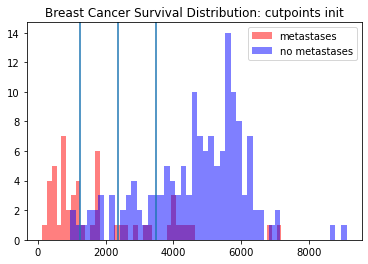

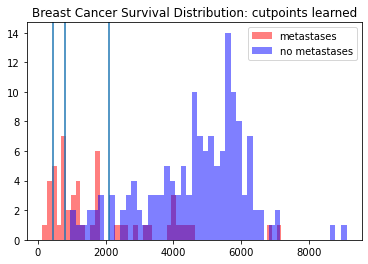

In [65]:
m.plot_result(y_df[y_df["e.tdm"]]["t.tdm"], 
              y_df[~y_df["e.tdm"]]["t.tdm"],
             title="Breast Cancer Survival Distribution",
             label_true="metastases",
             label_false="no metastases")

### Worcester Heart Attack Study

The dataset has 500 samples and 14 features. The endpoint is death, which occurred for 215 patients (43.0%).

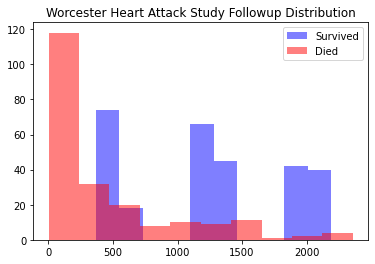

In [72]:
from sksurv.datasets import load_whas500

data_x, data_y = load_whas500()
y_df = pd.DataFrame.from_records(data_y)


X= data_x[["age", "bmi", "diasbp", "hr", "los", "sysbp"]].to_numpy()

t = np.array(y_df["lenfol"])
s = np.array(y_df["fstat"])

plt.title("Worcester Heart Attack Study Followup Distribution")
plt.hist(t[~y_df["fstat"].values], color="blue", alpha = 0.5, label="Survived")
plt.hist(t[y_df["fstat"].values], color="red", alpha = 0.5, label = "Died")
plt.legend()
plt.show()

In [73]:
m = CutpointModel(X, t, s, sigmoid_temperature = 0.001, depth = 1, iterations = 5000, prior_strength = 0.75)
m.train()


1
loss nan
cutpoint 0.25


ValueError: Expected value argument (Tensor of shape ()) to be within the support (Interval(lower_bound=0.0, upper_bound=1.0)) of the distribution Beta(), but found invalid values:
nan

In [ ]:
m.plot_result(t[y_df["fstat"].values], 
             t[~y_df["fstat"].values],
             title="Worcester Heart Attack Study Followup Distribution",
             label_true="Died",
             label_false="Survived")

# NACD Data

There are 51 features
There are 2402 patients


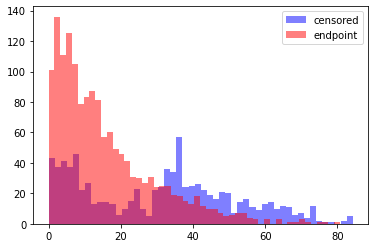

In [104]:
df= pd.read_csv('http://pssp.srv.ualberta.ca/system/predictors/datasets/000/000/032/original/All_Data_updated_may2011_CLEANED.csv?1350302245')
t = np.array(df["SURVIVAL"])
# make times positive
t += abs(min(t))

# censored: 1 is that they were censored 0 they experienced the event
s = np.array(1 - df["CENSORED"])

numrc_cols = df.nunique() > 2
df.loc[:, numrc_cols] = (df.loc[:, numrc_cols] - df.loc[:, numrc_cols].mean()) / df.loc[:, numrc_cols].std()

OUTCOMES = ['SURVIVAL', 'CENSORED']
X = df.drop(OUTCOMES, axis=1).sample(frac=1, random_state=2021)
X = X.values

print('There are', X.shape[1], 'features')
print(f"There are {X.shape[0]} patients")

plt.hist(t[s==0], bins=50, alpha = 0.5, color = "blue", label="censored")
plt.hist(t[s==1], bins=50, alpha = 0.5, color = "red", label="endpoint")
plt.legend()
plt.show()

In [105]:
m = CutpointModel(X, t, s, sigmoid_temperature = 0.001, depth = 1, iterations = 500, prior_strength = 0.75)
m.train()


1
loss 0.38771796226501465
cutpoint 0.25
2
loss 0.3346702456474304
cutpoint 0.25999999046325684
3
loss 0.2874387502670288
cutpoint 0.2625187933444977
4
loss 0.2535530924797058
cutpoint 0.2584400475025177
5
loss 0.2285248041152954
cutpoint 0.25485438108444214
6
loss 0.20844262838363647
cutpoint 0.2512819468975067
7
loss 0.1915643811225891
cutpoint 0.24966202676296234
8
loss 0.17434799671173096
cutpoint 0.24986299872398376
9
loss 0.1564202904701233
cutpoint 0.2514546513557434
10
loss 0.140330970287323
cutpoint 0.25392481684684753
11
loss 0.12698572874069214
cutpoint 0.2560577988624573
12
loss 0.11638295650482178
cutpoint 0.25624650716781616
13
loss 0.10835063457489014
cutpoint 0.2547708749771118
14
loss 0.10205131769180298
cutpoint 0.25287869572639465
15
loss 0.09625238180160522
cutpoint 0.25118952989578247
16
loss 0.09015852212905884
cutpoint 0.2502638101577759
17
loss 0.08510661125183105
cutpoint 0.2501963675022125
18
loss 0.080966055393219
cutpoint 0.2507142722606659
19
loss 0.0780346

146
loss 0.029793381690979004
cutpoint 0.25019320845603943
147
loss 0.029790103435516357
cutpoint 0.25018808245658875
148
loss 0.02978682518005371
cutpoint 0.2501830458641052
149
loss 0.029783785343170166
cutpoint 0.25018373131752014
150
loss 0.029780864715576172
cutpoint 0.2501837909221649
151
loss 0.029777884483337402
cutpoint 0.25018104910850525
152
loss 0.02977508306503296
cutpoint 0.2501809000968933
153
loss 0.02977222204208374
cutpoint 0.2501821219921112
154
loss 0.029769480228424072
cutpoint 0.25018033385276794
155
loss 0.029766857624053955
cutpoint 0.25017914175987244
156
loss 0.029764115810394287
cutpoint 0.2501811683177948
157
loss 0.029761433601379395
cutpoint 0.25018101930618286
158
loss 0.029759109020233154
cutpoint 0.25017786026000977
159
loss 0.029756665229797363
cutpoint 0.2501775622367859
160
loss 0.029754281044006348
cutpoint 0.2501797080039978
161
loss 0.02975177764892578
cutpoint 0.25017908215522766
162
loss 0.029749810695648193
cutpoint 0.25017720460891724
163
loss

288
loss 0.029628515243530273
cutpoint 0.25014644861221313
289
loss 0.02962815761566162
cutpoint 0.2501460909843445
290
loss 0.029627859592437744
cutpoint 0.25014597177505493
291
loss 0.029627501964569092
cutpoint 0.25014564394950867
292
loss 0.029627084732055664
cutpoint 0.2501453757286072
293
loss 0.02962672710418701
cutpoint 0.25014522671699524
294
loss 0.029626548290252686
cutpoint 0.2501448392868042
295
loss 0.02962625026702881
cutpoint 0.25014469027519226
296
loss 0.02962583303451538
cutpoint 0.25014442205429077
297
loss 0.029625535011291504
cutpoint 0.2501440942287445
298
loss 0.029625236988067627
cutpoint 0.25014394521713257
299
loss 0.0296248197555542
cutpoint 0.2501436471939087
300
loss 0.029624581336975098
cutpoint 0.2501433491706848
301
loss 0.02962428331375122
cutpoint 0.2501432001590729
302
loss 0.029623985290527344
cutpoint 0.2501428723335266
303
loss 0.029623568058013916
cutpoint 0.25014257431030273
304
loss 0.02962350845336914
cutpoint 0.25014248490333557
305
loss 0.02

loss 0.0296059250831604
cutpoint 0.2501145303249359
431
loss 0.029605865478515625
cutpoint 0.25011610984802246
432
loss 0.029605567455291748
cutpoint 0.2501138150691986
433
loss 0.029605746269226074
cutpoint 0.25011637806892395
434
loss 0.029605865478515625
cutpoint 0.25011274218559265
435
loss 0.0296056866645813
cutpoint 0.25011706352233887
436
loss 0.029605567455291748
cutpoint 0.25011110305786133
437
loss 0.029605567455291748
cutpoint 0.25011852383613586
438
loss 0.0296056866645813
cutpoint 0.2501084804534912
439
loss 0.029605448246002197
cutpoint 0.2501212954521179
440
loss 0.029605329036712646
cutpoint 0.2501039505004883
441
loss 0.029605388641357422
cutpoint 0.2501266896724701
442
loss 0.029605329036712646
cutpoint 0.2500956654548645
443
loss 0.029605329036712646
cutpoint 0.250137060880661
444
loss 0.029605388641357422
cutpoint 0.2500799000263214
445
loss 0.029605507850646973
cutpoint 0.2501571476459503
446
loss 0.029605627059936523
cutpoint 0.25004875659942627
447
loss 0.0296056

In [114]:
m.cutpoint0[1].item()

0.125

In [113]:
m.cutpoints[1].item()

0.09511663019657135

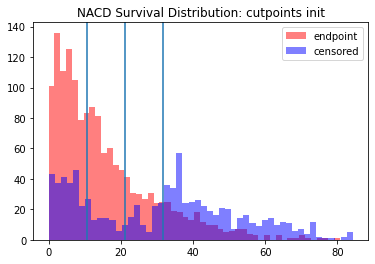

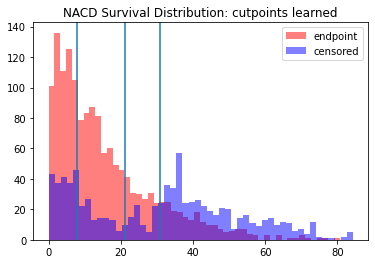

In [107]:
m.plot_result(t[s==1],
              t[s==0],
              title="NACD Survival Distribution",
              label_true = "endpoint",
              label_false = "censored"
             )

# Support dataset

There are 61 features
There are 9105 patients


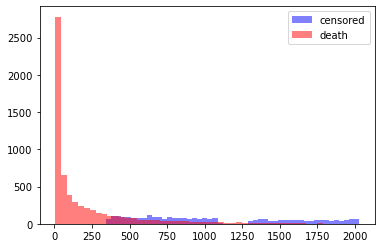

In [92]:
FILL_VALUES = {
    'alb': 3.5,
    'pafi': 333.3,
    'bili': 1.01,
    'crea': 1.01,
    'bun': 6.51,
    'wblc': 9.,
    'urine': 2502.
}

TO_DROP = ['aps', 'sps', 'surv2m', 'surv6m', 'prg2m', 'prg6m', 'dnr', 'dnrday']
TO_DROP = TO_DROP + ['sfdm2', 'hospdead']

# load, drop columns, fill using specified fill values
df = pd.read_csv('datasets/support2.csv').drop(TO_DROP,axis=1).fillna(value=FILL_VALUES)

# get dummies for categorical vars
df = pd.get_dummies(df, dummy_na=True)

# fill remaining values to the median

df = df.fillna(df.median())

# standardize numeric columns

numrc_cols = df.dtypes == 'float64'
df.loc[:, numrc_cols] = (df.loc[:, numrc_cols] - df.loc[:, numrc_cols].mean()) / df.loc[:, numrc_cols].std()

OUTCOMES = ['death', 'd.time']
X = df.drop(OUTCOMES, axis=1).sample(frac=1, random_state=2021)
X = X.values

t = np.array(df["d.time"])
s = np.array(df['death'])

print('There are', X.shape[1], 'features')
print(f'There are {X.shape[0]} patients')

plt.hist(t[s==0], bins=50, alpha = 0.5, color = "blue", label="censored")
plt.hist(t[s==1], bins=50, alpha = 0.5, color = "red", label="death")
plt.legend()
plt.show()

In [93]:
m = CutpointModel(X, t, s, sigmoid_temperature = 0.001, depth = 1, iterations = 1000, prior_strength = 0.75)
m.train()


1
loss nan
cutpoint 0.25


ValueError: Expected value argument (Tensor of shape ()) to be within the support (Interval(lower_bound=0.0, upper_bound=1.0)) of the distribution Beta(), but found invalid values:
nan

In [ ]:
m.plot_result(t[s==1],
              t[s==0],
              title="Support Survival Distribution",
              label_true = "endpoint",
              label_false = "censored"
             )